# 服务器日志数据分析

log.txt 文件记录了某个项目中某个 api 的调用情况，采样时间为每分钟一次，包括调用次数、响应时间等信息，大约18万条数据，下面进行探索性数据分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', **{'family':'SimHei'})

In [2]:
# 从log.txt导入数据

data = pd.read_table('log.txt', names=['id', 'api', 'count', 'res_time_sum', 'res_time_min',
                                       'res_time_max', 'res_time_avg', 'interval', 'created_at'])

In [3]:
data.head()

,id,api,count,res_time_sum,res_time_min,res_time_max,res_time_avg,interval,created_at
0,162542,/front-api/bill/create,8,1057.31,88.75,177.72,132.0,60,2017-11-01 00:00:07
1,162644,/front-api/bill/create,5,749.12,103.79,240.38,149.0,60,2017-11-01 00:01:07
2,162742,/front-api/bill/create,5,845.84,136.31,225.73,169.0,60,2017-11-01 00:02:07
3,162808,/front-api/bill/create,9,1305.52,90.12,196.61,145.0,60,2017-11-01 00:03:07
4,162943,/front-api/bill/create,3,568.89,138.45,232.02,189.0,60,2017-11-01 00:04:07


In [4]:
# 检查是否有重复值

data.duplicated().sum()

0

In [5]:
# 检查是否有空值

data.isnull().sum()

id              0
api             0
count           0
res_time_sum    0
res_time_min    0
res_time_max    0
res_time_avg    0
interval        0
created_at      0
dtype: int64

In [6]:
# 分析 api 和 interval 这两列的数据是否对分析有用

len(data)

179496

In [7]:
len(data[data['interval'] == 60])

179496

In [8]:
len(data[data['api'] == '/front-api/bill/create'])

179496

In [9]:
# 发现数据中每一行的 api 和 interval 字段的值都一样，所以丢弃这两列

data2 = data.drop(columns=['api', 'interval'])
data2.head()

,id,count,res_time_sum,res_time_min,res_time_max,res_time_avg,created_at
0,162542,8,1057.31,88.75,177.72,132.0,2017-11-01 00:00:07
1,162644,5,749.12,103.79,240.38,149.0,2017-11-01 00:01:07
2,162742,5,845.84,136.31,225.73,169.0,2017-11-01 00:02:07
3,162808,9,1305.52,90.12,196.61,145.0,2017-11-01 00:03:07
4,162943,3,568.89,138.45,232.02,189.0,2017-11-01 00:04:07


In [10]:
data2.describe()

,id,count,res_time_sum,res_time_min,res_time_max,res_time_avg
count,1.794960e+05,179496.000000,179496.000000,179496.000000,179496.000000,179496.000000
mean,6.866490e+06,7.175909,1393.177370,108.419620,359.880351,187.812208
std,3.686579e+06,4.325160,1499.485881,79.640559,638.919769,224.464813
min,1.625420e+05,1.000000,36.550000,3.210000,36.550000,36.000000
25%,3.825183e+06,4.000000,607.707500,83.410000,198.280000,144.000000
50%,6.811432e+06,7.000000,1154.905000,97.120000,256.090000,167.000000
75%,9.981397e+06,10.000000,1834.117500,116.990000,374.410000,202.000000
max,1.343909e+07,31.000000,142650.550000,18896.640000,142468.270000,71325.000000


In [11]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179496 entries, 0 to 179495
Data columns (total 7 columns):
id              179496 non-null int64
count           179496 non-null int64
res_time_sum    179496 non-null float64
res_time_min    179496 non-null float64
res_time_max    179496 non-null float64
res_time_avg    179496 non-null float64
created_at      179496 non-null object
dtypes: float64(4), int64(2), object(1)
memory usage: 9.6+ MB


In [12]:
# 使用 created_at 这⼀列的数据作为时间索引

#data2 = data2.set_index('created_at')
data2.index = pd.to_datetime(data2['created_at'])

In [13]:
data2.head()

,id,count,res_time_sum,res_time_min,res_time_max,res_time_avg,created_at
created_at,,,,,,,
2017-11-01 00:00:07,162542,8,1057.31,88.75,177.72,132.0,2017-11-01 00:00:07
2017-11-01 00:01:07,162644,5,749.12,103.79,240.38,149.0,2017-11-01 00:01:07
2017-11-01 00:02:07,162742,5,845.84,136.31,225.73,169.0,2017-11-01 00:02:07
2017-11-01 00:03:07,162808,9,1305.52,90.12,196.61,145.0,2017-11-01 00:03:07
2017-11-01 00:04:07,162943,3,568.89,138.45,232.02,189.0,2017-11-01 00:04:07


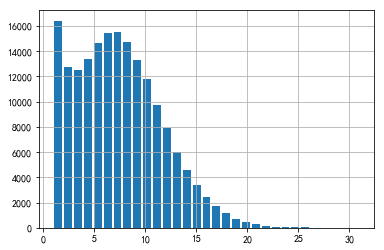

In [14]:
# 分析 api 调用次数情况
# 下面直方图表示单位时间调用api的次数，最大值为31，所以就分31组吧

data['count'].hist(bins=31, rwidth=0.8)
plt.show()

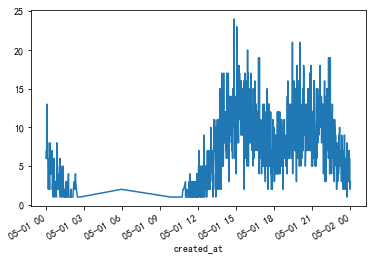

In [15]:
# 分析 api 调用次数情况，例如，在2018-5-1这一天中，哪些时间是访问高峰，哪些时间段访问比较少
# 如下图所示，从凌晨2点到11点访问少，业务高峰出现在下午两三点，晚上八九点。

data2['2018-5-1']['count'].plot()
plt.show()

In [16]:
data2['2018-5-1'].describe()

,id,count,res_time_sum,res_time_min,res_time_max,res_time_avg
count,8.840000e+02,884.000000,884.000000,884.000000,884.000000,884.000000
mean,1.144256e+07,7.407240,1762.250656,111.870498,521.017387,226.088235
std,1.968142e+04,4.428032,1717.479213,76.719324,510.199840,138.679916
min,1.140613e+07,1.000000,68.300000,31.310000,68.300000,68.000000
25%,1.142682e+07,4.000000,718.525000,80.110000,228.227500,157.000000
50%,1.144302e+07,7.000000,1426.740000,95.515000,354.105000,194.000000
75%,1.145930e+07,10.000000,2365.845000,119.667500,605.042500,252.250000
max,1.147566e+07,24.000000,23595.600000,1694.470000,4664.840000,1815.000000


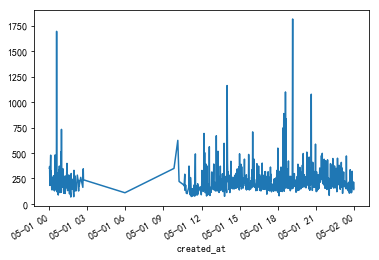

In [17]:
# 分析一天中 api 响应时间

data2['2018-5-1']['res_time_avg'].plot()
plt.show()

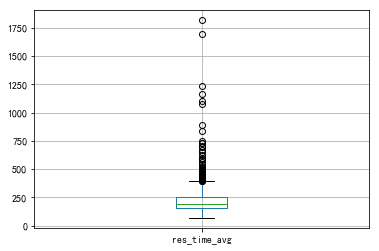

In [18]:
data2['2018-5-1'][['res_time_avg']].boxplot()
plt.show()

In [19]:
data3 = data2['2018-5-1']
#len(data3)
data3[data3['res_time_avg']>1000]

,id,count,res_time_sum,res_time_min,res_time_max,res_time_avg,created_at
created_at,,,,,,,
2018-05-01 00:34:48,11408773,1,1694.47,1694.47,1694.47,1694.0,2018-05-01 00:34:48
2018-05-01 14:00:49,11431010,17,19770.18,207.54,2974.52,1162.0,2018-05-01 14:00:49
2018-05-01 18:36:49,11451787,8,8799.92,96.59,3233.26,1099.0,2018-05-01 18:36:49
2018-05-01 19:09:49,11454117,6,7399.94,307.39,3153.02,1233.0,2018-05-01 19:09:49
2018-05-01 19:10:49,11454151,13,23595.60,206.20,4664.84,1815.0,2018-05-01 19:10:49
2018-05-01 20:38:49,11460717,15,16169.25,142.47,3624.26,1077.0,2018-05-01 20:38:49


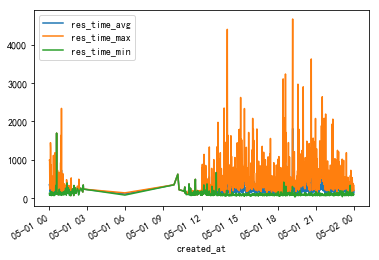

In [20]:
#data2['2018-5-1'][['res_time_avg','res_time_max','res_time_min','res_time_sum']].plot()
data2['2018-5-1'][['res_time_avg','res_time_max','res_time_min']].plot()
plt.show()

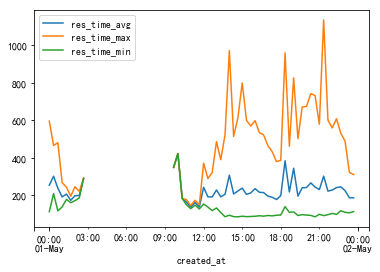

In [21]:
# 以20分钟为单位重新采样，可以看到在业务高峰时间段，最大响应时间和平均响应时间都有所上升

#data2['2018-5-1'].resample('20T').mean()[['res_time_avg','res_time_max','res_time_min','res_time_sum']].plot()
data2['2018-5-1'].resample('20T').mean()[['res_time_avg','res_time_max','res_time_min']].plot()
plt.show()

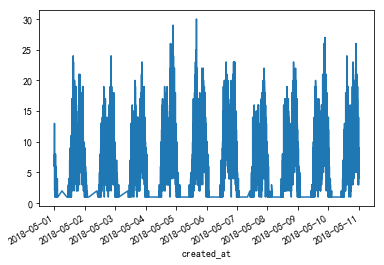

In [22]:
# 分析连续的几天数据，可以发现，每天的业务高峰时段都比较相似

data2['2018-5-1':'2018-5-10']['count'].plot()
plt.show()

In [23]:
# 分析周末访问量是否有增加

data2['weekday'] = data2.index.weekday
data2.head()

,id,count,res_time_sum,res_time_min,res_time_max,res_time_avg,created_at,weekday
created_at,,,,,,,,
2017-11-01 00:00:07,162542,8,1057.31,88.75,177.72,132.0,2017-11-01 00:00:07,2
2017-11-01 00:01:07,162644,5,749.12,103.79,240.38,149.0,2017-11-01 00:01:07,2
2017-11-01 00:02:07,162742,5,845.84,136.31,225.73,169.0,2017-11-01 00:02:07,2
2017-11-01 00:03:07,162808,9,1305.52,90.12,196.61,145.0,2017-11-01 00:03:07,2
2017-11-01 00:04:07,162943,3,568.89,138.45,232.02,189.0,2017-11-01 00:04:07,2


In [24]:
# weekday从0开始，5和6表示星期六和星期天

data2['weekend'] = data2['weekday'].isin({5,6})
data2.head()

,id,count,res_time_sum,res_time_min,res_time_max,res_time_avg,created_at,weekday,weekend
created_at,,,,,,,,,
2017-11-01 00:00:07,162542,8,1057.31,88.75,177.72,132.0,2017-11-01 00:00:07,2,False
2017-11-01 00:01:07,162644,5,749.12,103.79,240.38,149.0,2017-11-01 00:01:07,2,False
2017-11-01 00:02:07,162742,5,845.84,136.31,225.73,169.0,2017-11-01 00:02:07,2,False
2017-11-01 00:03:07,162808,9,1305.52,90.12,196.61,145.0,2017-11-01 00:03:07,2,False
2017-11-01 00:04:07,162943,3,568.89,138.45,232.02,189.0,2017-11-01 00:04:07,2,False


In [25]:
data2.groupby('weekend')['count'].mean()
data2.head()

,id,count,res_time_sum,res_time_min,res_time_max,res_time_avg,created_at,weekday,weekend
created_at,,,,,,,,,
2017-11-01 00:00:07,162542,8,1057.31,88.75,177.72,132.0,2017-11-01 00:00:07,2,False
2017-11-01 00:01:07,162644,5,749.12,103.79,240.38,149.0,2017-11-01 00:01:07,2,False
2017-11-01 00:02:07,162742,5,845.84,136.31,225.73,169.0,2017-11-01 00:02:07,2,False
2017-11-01 00:03:07,162808,9,1305.52,90.12,196.61,145.0,2017-11-01 00:03:07,2,False
2017-11-01 00:04:07,162943,3,568.89,138.45,232.02,189.0,2017-11-01 00:04:07,2,False


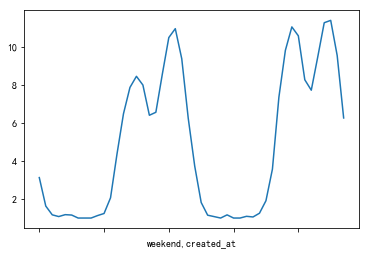

In [26]:
data2.groupby(['weekend', data2.index.hour])['count'].mean().plot()
plt.show()

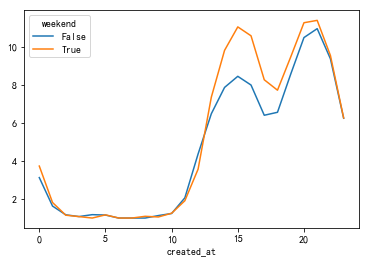

In [27]:
# 可以发现，周末的下午和晚上，比非周末的访问量多一些

data2.groupby(['weekend', data2.index.hour])['count'].mean().unstack(level=0).plot()
plt.show()